In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
from cellpose_omni import models, core
from glob import glob
from natsort import natsorted

# This checks to see if you have set up your GPU properly.
# CPU performance is a lot slower, but not a problem if you
# are only processing a few images.
use_GPU = core.use_gpu()
print('>>> GPU activated? %d'%use_GPU)

import tifffile
from skimage.transform import rescale, resize, downscale_local_mean

# for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image

2023-08-29 00:44:43,102 [INFO] OpenGL_accelerate module loaded
2023-08-29 00:44:43,108 [INFO] Using accelerated ArrayDatatype
2023-08-29 00:44:43,903 [INFO] ** TORCH GPU version installed and working. **
>>> GPU activated? 1


In [10]:
test_data = []
image_dirs = natsorted(glob("membrane_test_data/*"))
for image_dir in image_dirs:
    if "mask" not in image_dir:
        test_data.append(
            np.array(Image.open(image_dir))
        )


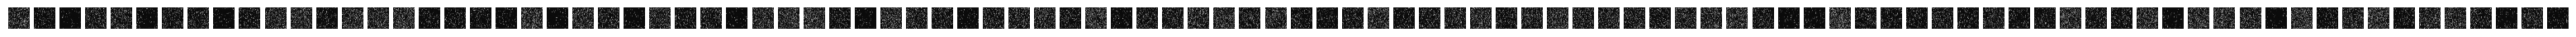

In [11]:
from cellpose_omni import io
from cellpose_omni import io, transforms
from omnipose.utils import normalize99
import omnipose
imgs = test_data
nimg = len(imgs)
fig = plt.figure(figsize=[40]*2) # initialize figure
for k in range(len(imgs)):
    img = transforms.move_min_dim(imgs[k]) # move the channel dimension last
    if len(img.shape)>2:
        imgs[k] = np.mean(img,axis=-1) # or just turn into grayscale

    imgs[k] = normalize99(imgs[k])
    plt.subplot(1,len(imgs),k+1)
    plt.imshow(imgs[k],cmap='gray')
    plt.axis('off')

In [26]:

model_list = natsorted(glob("membrane_training_data//models/*"))
model_name = model_list[-2]
print(model_name)
use_gpu = use_GPU# = False
model = models.CellposeModel(gpu=use_gpu, pretrained_model=model_name, omni=True, concatenation=True)

membrane_training_data//models/cellpose_residual_on_style_on_concatenation_off_omni_nclasses_4_membrane_training_data_2023_08_13_23_06_24.701925_epoch_3901
2023-08-29 00:58:08,076 [INFO] ** TORCH GPU version installed and working. **
2023-08-29 00:58:08,077 [INFO] >>>> using GPU


In [27]:
chans = [0,0] #this means segment based on first channel, no second channel
n = range(nimg) # or just segment them all

# define parameters
mask_threshold = -1
verbose = 0 # turn on if you want to see more output
use_gpu = use_GPU #defined above
transparency = True # transparency in flow output
rescale=None # give this a number if you need to upscale or downscale your images
omni = True # we can turn off Omnipose mask reconstruction, not advised
flow_threshold = 0. # default is .4, but only needed if there are spurious masks to clean up; slows down output
resample = True #whether or not to run dynamics on rescaled grid or original grid
masks_syntrained, flows, styles = model.eval([imgs[i] for i in n],channels=chans,rescale=rescale,mask_threshold=mask_threshold,transparency=transparency,
                                  flow_threshold=flow_threshold,omni=omni,resample=resample,verbose=verbose)

  0%|          | 0/100 [00:00<?, ?it/s]

In [14]:
use_gpu = use_GPU# = False
model = models.CellposeModel(gpu=use_gpu, model_type="bact_fluor_omni", omni=True, concatenation=True)
chans = [0,0] #this means segment based on first channel, no second channel
n = range(nimg) # or just segment them all
masks_pretrained, flows, styles = model.eval([imgs[i] for i in n],channels=chans,rescale=rescale,mask_threshold=mask_threshold,transparency=transparency,
                                  flow_threshold=flow_threshold,omni=omni,resample=resample,verbose=verbose)

2023-08-29 00:46:51,004 [INFO] >>bact_fluor_omni<< model set to be used
2023-08-29 00:46:51,019 [INFO] ** TORCH GPU version installed and working. **
2023-08-29 00:46:51,020 [INFO] >>>> using GPU


In [28]:
try:
    os.mkdir("membrane_segmented_test_images/")
except:
    pass

In [29]:
for idx,i in enumerate(n):
    Image.fromarray(masks_pretrained[idx]).save(f"membrane_segmented_test_images//pretrained_{idx}.png")
    Image.fromarray(masks_syntrained[idx]).save(f"membrane_segmented_test_images//syntrained_{idx}.png")